# **Car Price Prediction - Kaggle Competition**

[Kaggle](https://www.kaggle.com/competitions/autoam-car-price-prediction/overview)

**Importing Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, r2_score
import warnings
import shap

# Disable warnings
warnings.filterwarnings("ignore")

#PART 1: Kaggle Data

**Loading Data**

In [ ]:
train = pd.read_csv('train.csv')

**EDA**

In [ ]:
train.head()

,model,year,motor_type,running,wheel,color,type,status,motor_volume,price
0,toyota,2022,petrol,3000 km,left,skyblue,sedan,excellent,2.0,24500
1,mercedes-benz,2014,petrol,132000 km,left,black,sedan,excellent,2.0,25500
2,kia,2018,petrol,95000 miles,left,other,sedan,excellent,2.0,11700
3,mercedes-benz,2002,petrol,137000 miles,left,golden,sedan,excellent,3.2,12000
4,mercedes-benz,2017,petrol,130000 km,left,black,sedan,good,2.0,26000


*It is possible to see that the running column has type issues so this will be fixed.*

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1642 entries, 0 to 1641
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         1642 non-null   object 
 1   year          1642 non-null   int64  
 2   motor_type    1642 non-null   object 
 3   running       1642 non-null   object 
 4   wheel         1642 non-null   object 
 5   color         1642 non-null   object 
 6   type          1642 non-null   object 
 7   status        1642 non-null   object 
 8   motor_volume  1642 non-null   float64
 9   price         1642 non-null   int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 128.4+ KB


In [ ]:
train.describe()

,year,motor_volume,price
count,1642.000000,1642.000000,1642.000000
mean,2014.805725,2.035018,15982.633374
std,6.587573,0.253069,7176.084647
min,1987.000000,0.200000,462.000000
25%,2013.000000,2.000000,12000.000000
50%,2017.000000,2.000000,15750.000000
75%,2019.000000,2.000000,18500.000000
max,2023.000000,4.000000,87000.000000


**Removing Outliers**

In [ ]:
# Calculate the first and third quartiles for the price column
Q1 = train['price'].quantile(0.25)
Q3 = train['price'].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
train_clean = train[(train['price'] >= lower_bound) & (train['price'] <= upper_bound)]

print("Original data shape:", train.shape)
print("Clean data shape:", train_clean.shape)


Original data shape: (1642, 10)
Clean data shape: (1550, 10)


In [ ]:
train.isnull().sum()

,0
model,0
year,0
motor_type,0
running,0
wheel,0
color,0
type,0
status,0
motor_volume,0
price,0


In [ ]:
train.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
year,1642.0,2014.81,6.59,1987.0,2013.0,2017.0,2019.0,2023.0
motor_volume,1642.0,2.04,0.25,0.2,2.0,2.0,2.0,4.0
price,1642.0,15982.63,7176.08,462.0,12000.0,15750.0,18500.0,87000.0


In [ ]:
unique_counts = train.nunique()
print(unique_counts)

model             5
year             32
motor_type        5
running         643
wheel             1
color            17
type              7
status            5
motor_volume     20
price           294
dtype: int64


*Wheel has only 1 value so it will be dropped.*

In [ ]:
train["color"].unique()

array(['skyblue', 'black', 'other', 'golden', 'blue', 'gray', 'silver',
       'white', 'clove', 'orange', 'red', 'green', 'cherry', 'brown',
       'beige', 'purple', 'pink'], dtype=object)

In [ ]:
train["type"].unique()

array(['sedan', 'suv', 'Universal', 'Coupe', 'pickup', 'hatchback',
       'minivan / minibus'], dtype=object)

In [ ]:
train["status"].unique()

array(['excellent', 'good', 'crashed', 'normal', 'new'], dtype=object)

In [ ]:
train["model"].unique()

array(['toyota', 'mercedes-benz', 'kia', 'nissan', 'hyundai'],
      dtype=object)

In [ ]:
train["motor_type"].unique()

array(['petrol', 'gas', 'petrol and gas', 'diesel', 'hybrid'],
      dtype=object)

**Cleaning Data**

In [ ]:
df=train_clean.copy()

In [ ]:
# Running has mixed types, for example 3000 km and 950 miles, this function fix that:
def convert_running(value):
    value = value.lower().replace(' ', '') # First remove spaces
    if 'km' in value:
        return float(value.replace('km', '')) # Keeps number in km and removes "km"
    elif 'miles' in value:
        return float(value.replace('miles', '')) * 1.60934 # Converts miles to km and removes "miles"
    else:
        return np.nan

df['running_km'] = df['running'].apply(convert_running) # Changes the name of the column
df.drop(columns=['running'], inplace=True) # Drops old column

In [ ]:
df.drop(columns=['wheel'], inplace=True) # Drops old column
df.head()

,model,year,motor_type,color,type,status,motor_volume,price,running_km
0,toyota,2022,petrol,skyblue,sedan,excellent,2.0,24500,3000.00
1,mercedes-benz,2014,petrol,black,sedan,excellent,2.0,25500,132000.00
2,kia,2018,petrol,other,sedan,excellent,2.0,11700,152887.30
3,mercedes-benz,2002,petrol,golden,sedan,excellent,3.2,12000,220479.58
4,mercedes-benz,2017,petrol,black,sedan,good,2.0,26000,130000.00


We will use random forest because this model combines multiple decision trees to improve accuracy, reduce overfitting, and handle complex relationships in data.
Random Forest does not handle categorical data natively, so we need to encode those features first.
We will convert categorical features using One-Hot Encoding, but Label Encoding could be used if the first approach does not work.

In [ ]:
# One-hot encode categorical features (columns: 'model', 'motor_type', 'color', 'type', 'status')
categorical_columns = ['model', 'motor_type', 'color', 'type', 'status']
df_encoded = pd.get_dummies(df, columns=categorical_columns)

**Cross-validation**

In [ ]:
# Separate features and target
X = df_encoded.drop('price', axis=1)
y = df_encoded['price']

# Set up 5-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=2025)
fold = 1
train_mae_list = []
test_mae_list = []
train_r2_list = []
test_r2_list = []

In [ ]:
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train Random Forest model
    rf = RandomForestRegressor(random_state=2025, max_depth=10)
    rf.fit(X_train, y_train)

    # Simple predictions
    train_preds = rf.predict(X_train)
    test_preds = rf.predict(X_test)

    # Compute MAE for train and test
    train_mae = mean_absolute_error(y_train, train_preds)
    test_mae = mean_absolute_error(y_test, test_preds)

    # Compute R² score for train and test (used as an "accuracy" metric)
    train_r2 = r2_score(y_train, train_preds)
    test_r2 = r2_score(y_test, test_preds)

    train_mae_list.append(train_mae)
    test_mae_list.append(test_mae)

    train_r2_list.append(train_r2)
    test_r2_list.append(test_r2)


    print(f"Fold {fold}:")
    print(f"  Train MAE = {train_mae:.2f}")
    print(f"  Test MAE = {test_mae:.2f}")

    print(f"  Train R²  = {train_r2:.2f}")
    print(f"  Test R²  = {test_r2:.2f}")

    print("  Sample predictions:")

    for i in range(min(3, len(X_test))):
        print(f"    Sample {i+1}: Predicted = {test_preds[i]:.2f}, Actual = {y_test.iloc[i]}")
    print("\n")
    fold += 1

print(f"Average Train MAE (CV): {np.mean(train_mae_list):.2f}")
print(f"Average Test MAE (CV): {np.mean(test_mae_list):.2f}")

print(f"Average Train r2: {np.mean(train_r2_list):.2f}")
print(f"Average Test r2: {np.mean(test_r2_list):.2f}")



Fold 1:
  Train MAE = 1065.14
  Test MAE = 1712.73
  Train R²  = 0.93
  Test R²  = 0.79
  Sample predictions:
    Sample 1: Predicted = 15680.29, Actual = 15300
    Sample 2: Predicted = 25523.78, Actual = 23800
    Sample 3: Predicted = 12247.69, Actual = 12300


Fold 2:
  Train MAE = 1049.60
  Test MAE = 1769.56
  Train R²  = 0.93
  Test R²  = 0.79
  Sample predictions:
    Sample 1: Predicted = 17643.41, Actual = 25500
    Sample 2: Predicted = 23652.89, Actual = 26000
    Sample 3: Predicted = 6159.35, Actual = 6000


Fold 3:
  Train MAE = 1075.18
  Test MAE = 1723.31
  Train R²  = 0.93
  Test R²  = 0.77
  Sample predictions:
    Sample 1: Predicted = 25211.63, Actual = 24500
    Sample 2: Predicted = 6288.77, Actual = 12000
    Sample 3: Predicted = 24750.54, Actual = 7000


Fold 4:
  Train MAE = 1060.62
  Test MAE = 1785.13
  Train R²  = 0.93
  Test R²  = 0.75
  Sample predictions:
    Sample 1: Predicted = 13480.15, Actual = 11700
    Sample 2: Predicted = 18081.42, Actual = 185

*Price has a mean of 15982.63, so MAE = 1731 it's not great, but it is a reasonable result.*

**Feature Selection**

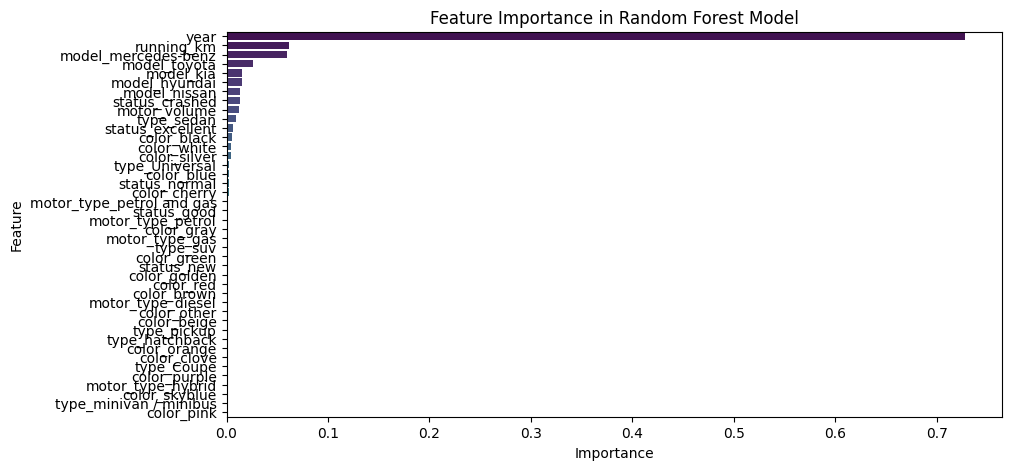

Top 20 features: ['year', 'running_km', 'model_mercedes-benz', 'model_toyota', 'model_kia', 'model_hyundai', 'model_nissan', 'status_crashed', 'motor_volume', 'type_sedan', 'status_excellent', 'color_black', 'color_white', 'color_silver', 'type_Universal', 'color_blue', 'status_normal', 'color_cherry', 'motor_type_petrol and gas', 'status_good']


In [ ]:
# Train a final model on the full training data to compute feature importances
final_rf = RandomForestRegressor(random_state=2025, max_depth=10)
final_rf.fit(X, y)

# Get feature importances
feature_importances = final_rf.feature_importances_
importance_df = pd.DataFrame({"Feature": X.columns, "Importance": feature_importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 5))
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")
plt.title("Feature Importance in Random Forest Model")
plt.show()

# Retain only the top 20 most important features
top20_features = importance_df.head(20)["Feature"].tolist()
print("Top 20 features:", top20_features)

# Reduce the training data to the top 20 features
X_reduced = X[top20_features]



**Visualization on Full Training Data**

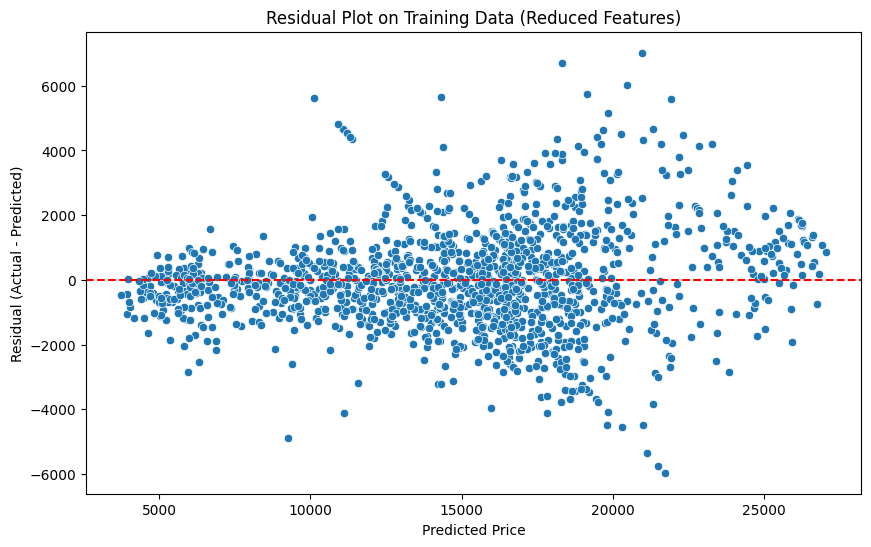

In [ ]:
# Train final model on reduced feature set
final_rf_reduced = RandomForestRegressor(random_state=2025, max_depth=10)
final_rf_reduced.fit(X_reduced, y)

# Get predictions on full training data
train_preds_reduced = final_rf_reduced.predict(X_reduced)

# 1. Residual Plot: Residuals (actual - predicted) vs. predicted values
residuals = y - train_preds_reduced
plt.figure(figsize=(10, 6))
sns.scatterplot(x=train_preds_reduced, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Price")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residual Plot on Training Data (Reduced Features)")
plt.show()

*Errors are randomly distributed, which is a sign of a good model, but there are some outliers that need attention.*

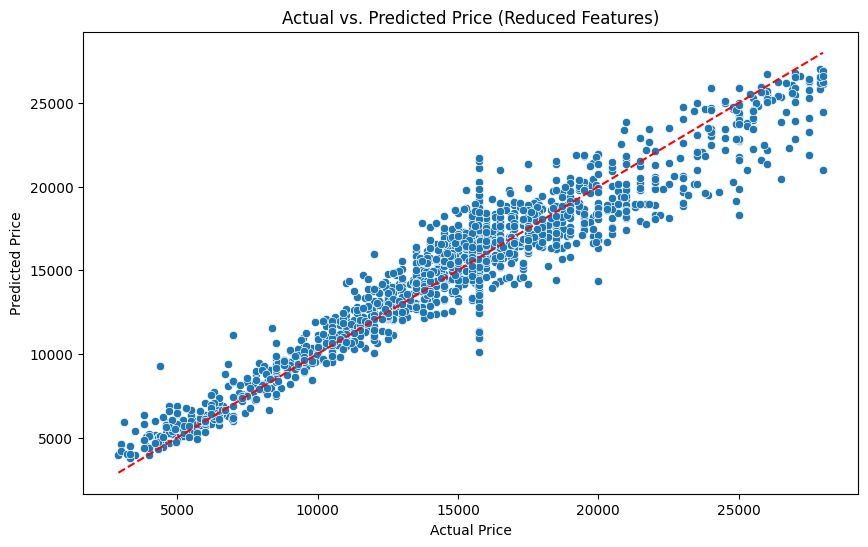

In [ ]:
# 2. Actual vs. Predicted Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y, y=train_preds_reduced)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs. Predicted Price (Reduced Features)")
plt.show()



*The points are close to the red diagonal line, so the model is performing well.*

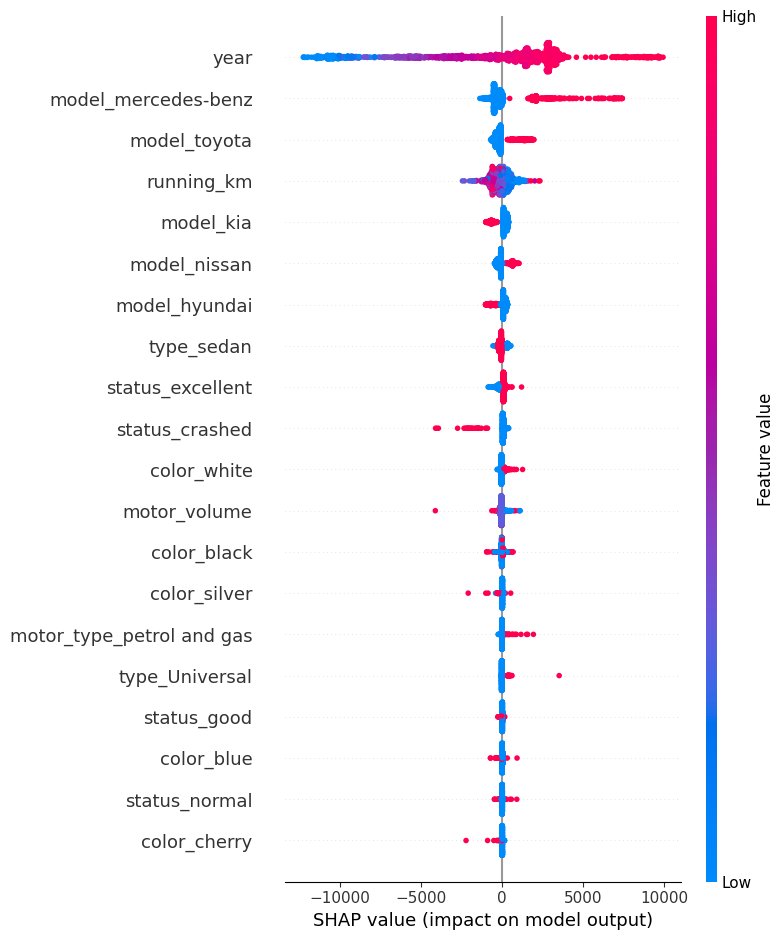

In [ ]:
# 3. SHAP Summary Plot for the Reduced Model
# Initialize the SHAP explainer for tree models and calculate SHAP values
explainer = shap.TreeExplainer(final_rf_reduced)
shap_values = explainer.shap_values(X_reduced)
# Display a SHAP summary (beeswarm) plot
shap.summary_plot(shap_values, X_reduced)

*This shows how much each feature contributes to the prediction.*

*Negative values (left side) decrease the predicted price.*

*Positive values (right side) increase the predicted price.*

*Newer cars increase the predicted price; Being a Mercedes-Benz is associated with higher car prices; More kilometers driven leads to a lower price; Damaged cars lower the predicted price.*

#PART 2: Predicting on Canadian Data

In [ ]:
#Load the Canadian dataset
df_can = pd.read_excel("CanadianData.xlsx")
df_can.drop(columns=['price (CAD)'], inplace=True) # Drops old column
df_can.drop(columns=['wheel'], inplace=True) # Drops old column

df_can.head(25)

,model,year,motor_type,color,type,status,motor_volume,price,running_km
0,toyota,2015,gas,white,sedan,excellent,1.8,9592.60,154930
1,toyota,2009,gas,gray,sedan,good,1.8,7610.30,98000
2,toyota,2020,gas,black,suv,excellent,2.5,25139.52,89530
3,toyota,2023,gas,black,Coupe,excellent,3.0,44377.12,16150
4,toyota,2023,gas,black,suv,excellent,2.5,25023.00,28968
5,kia,2022,gas,red,suv,excellent,2.5,21097.94,54004
6,kia,2022,gas,black,sedan,excellent,1.6,18828.56,66998
7,kia,2016,gas,brown,sedan,good,2.0,6271.30,189036
8,nissan,2022,gas,black,sedan,excellent,3.5,18821.16,100107
9,nissan,2021,gas,black,suv,excellent,2.5,16977.52,65001


In [ ]:
df_can.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         18 non-null     object 
 1   year          18 non-null     int64  
 2   motor_type    18 non-null     object 
 3   color         18 non-null     object 
 4   type          18 non-null     object 
 5   status        18 non-null     object 
 6   motor_volume  18 non-null     float64
 7   price         18 non-null     float64
 8   running_km    18 non-null     int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 1.4+ KB


In [ ]:
# One-hot encode the Canadian data using the same categorical columns
df_can_encoded = pd.get_dummies(df_can, columns=categorical_columns)

# Align the Canadian dataset to have the same features as the training data
df_can_encoded = df_can_encoded.reindex(columns=X.columns, fill_value=0)

# Reduce Canadian data to the selected top 20 features
df_can_reduced = df_can_encoded[top20_features]

# Get the actual prices from the Canadian dataset (assumed to be in the 'price' column)
y_can = df_can['price']

# Use the reduced model to predict on the Canadian data
can_preds_reduced = final_rf_reduced.predict(df_can_reduced)

# Create a new DataFrame with predicted price and real price
results_df = pd.DataFrame({
    'predicted_price': can_preds_reduced,
    'actual_price': y_can
})

# Add a column for error percentage (rounded to 0 decimals)
results_df['error_percentage'] = (((results_df['predicted_price'] - results_df['actual_price']) /
                                    results_df['actual_price']) * 100).round(0)

print("\nCanadian Data Predictions:")
print(results_df.head(25))


Canadian Data Predictions:
    predicted_price  actual_price  error_percentage
0      15535.037742       9592.60              62.0
1       9982.440702       7610.30              31.0
2      19862.951713      25139.52             -21.0
3      16304.594045      44377.12             -63.0
4      15767.527706      25023.00             -37.0
5      12781.400000      21097.94             -39.0
6      20966.825466      18828.56              11.0
7      11131.927290       6271.30              78.0
8      12437.500000      18821.16             -34.0
9      11871.558333      16977.52             -30.0
10     17451.741957      13688.52              27.0
11     18875.625001      28747.74             -34.0
12     15931.507420      12235.12              30.0
13     16539.418085      22198.52             -25.0
14     21454.052753      12950.00              66.0
15     14335.333333      24973.98             -43.0
16     13119.250000      41766.30             -69.0
17     23741.316703      11803.00   

In [ ]:
# Final MAE Calculation on Full Training Data and Canadian Data (Reduced Features)
final_train_mae = mean_absolute_error(y, train_preds_reduced)
can_mae = mean_absolute_error(y_can, can_preds_reduced)
print(f"\nFinal Model Train MAE (Full Data, Reduced Features): {final_train_mae:.2f}")
print(f"Final Model Test MAE (Canadian Data, Reduced Features): {can_mae:.2f}")


Final Model Train MAE (Full Data, Reduced Features): 1103.01
Final Model Test MAE (Canadian Data, Reduced Features): 8913.51
